# Import Libraries

In [1]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from keras.utils import get_file
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
from torch import nn
import pandas as pd
import numpy as np
import torch
import os

2023-11-22 15:31:42.437968: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 15:31:42.543640: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 15:31:42.543679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 15:31:42.543704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 15:31:42.567186: I tensorflow/core/platform/cpu_feature_g

# Load the Dataset

In [2]:
# Download the data and unzip it
zip_path = get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True,
)

# extract the csv path
csv_path, _ = os.path.splitext(zip_path)

In [3]:
# Load the data
df = pd.read_csv(csv_path)

# EDA

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


- There's no missing values in the dataset.
- Convert the `Date Time` column to a suitable format for Pandas.
- Set the `Date Time` column as the index.

In [6]:
df_copy = df.copy()

In [7]:
# Reformat the date time column to be a datetime object
df_copy.index = pd.to_datetime(df_copy.pop("Date Time"), format=r"%d.%m.%Y %H:%M:%S")

In [8]:
df_copy.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Visualizations

### Data Visualization

In [9]:
# Titles for the plots
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

# Column names in the dataset
features = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

In [10]:
# Visualize all the features overtime as subplots
def visualize_features(data: pd.DataFrame, nrows=7, ncols=2) -> None:
    sns.set_style("whitegrid")
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 25))
    for feature, title, ax in zip(features, titles, axes.flatten()):
        t_data = data[feature]
        t_data.index = data.index

        ax = t_data.plot(
            ax=ax,
            title="{} - {}".format(title, feature),
            rot=25,
        )
        ax.legend([title])
    plt.tight_layout()

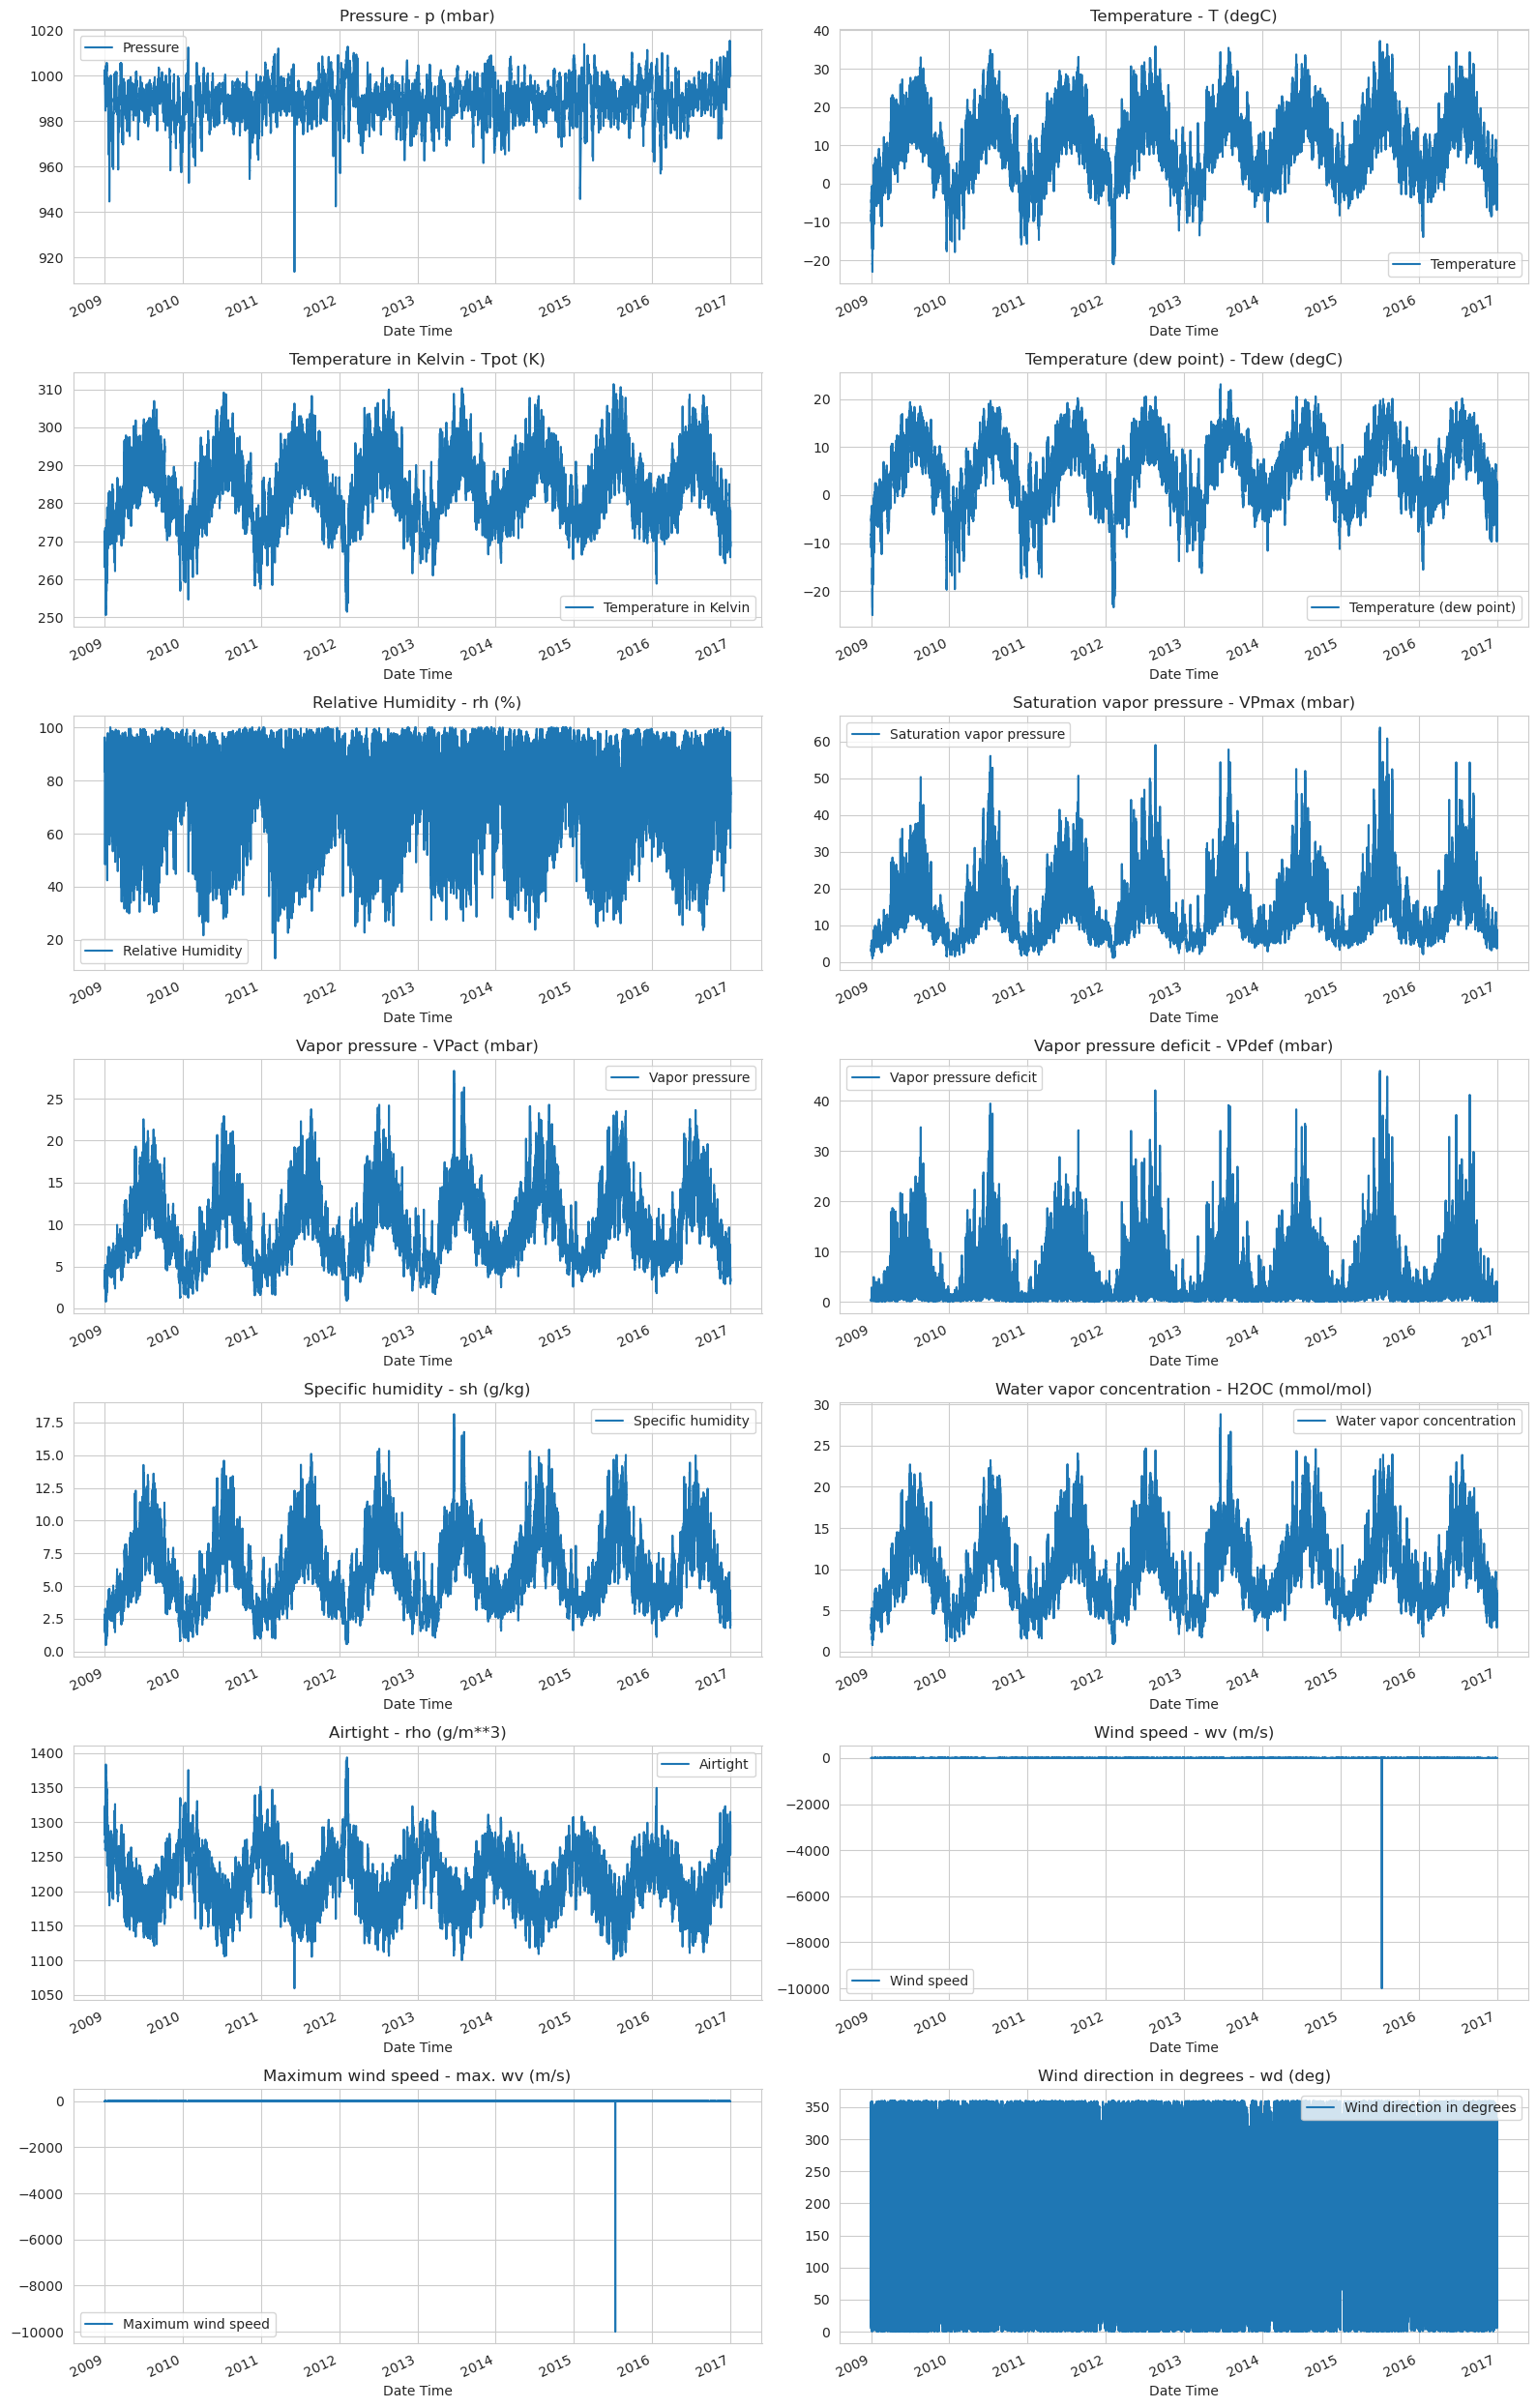

In [11]:
visualize_features(df_copy)

- Wind velocities have a bad reading (-9999) which is an outlier.
- There's a Temperature column but in Kelvin, so we will drop it and use the Temperature in Celsius as label instead.


### Visualize Correlation

In [12]:
df_vis = df_copy.copy()
df_vis.columns = titles  # rename the columns for more readability

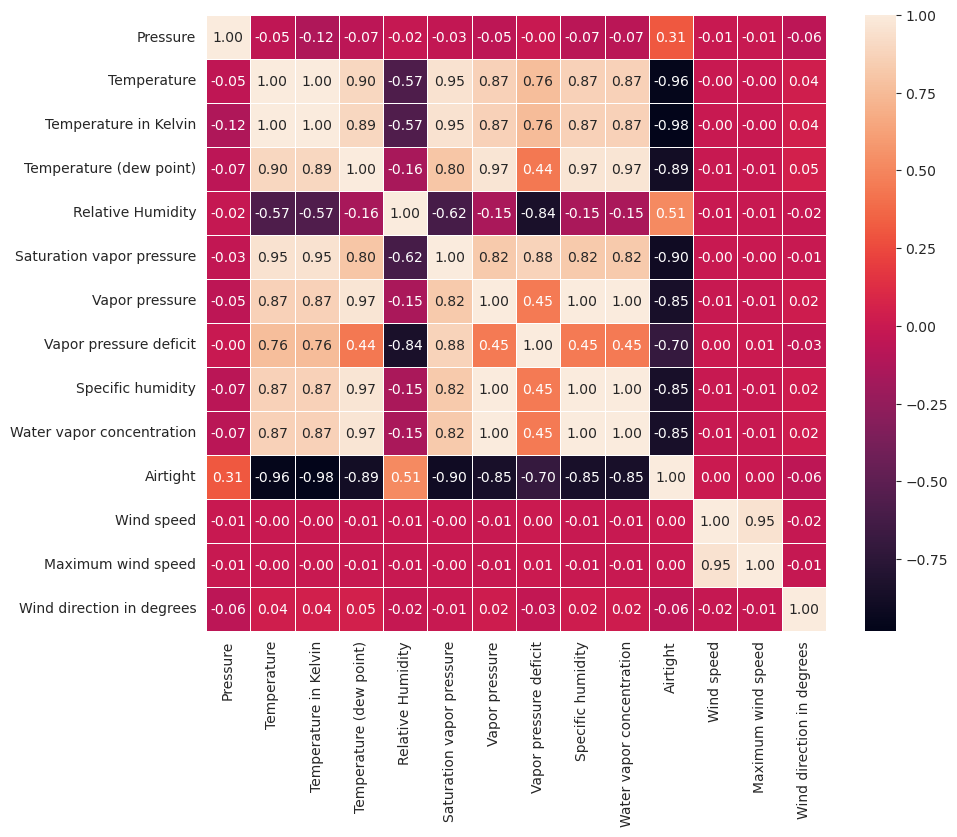

In [13]:
df_vis_corr = df_vis.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_vis_corr, annot=True, fmt=".2f", linewidths=0.5)
plt.show()

In [14]:
df_vis_corr["Temperature"].sort_values(ascending=False)

Temperature                  1.000000
Temperature in Kelvin        0.996827
Saturation vapor pressure    0.951113
Temperature (dew point)      0.895708
Vapor pressure               0.867673
Water vapor concentration    0.867177
Specific humidity            0.866755
Vapor pressure deficit       0.761744
Wind direction in degrees    0.038732
Maximum wind speed          -0.002871
Wind speed                  -0.004689
Pressure                    -0.045375
Relative Humidity           -0.572416
Airtight                    -0.963410
Name: Temperature, dtype: float64

- There's nearly no correlation between wind velocities and temperature.

In [15]:
df_stats = df_copy.describe().transpose()
df_stats.index = titles

df_stats

,count,mean,std,min,25%,50%,75%,max
Pressure,420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
Temperature,420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Temperature in Kelvin,420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Temperature (dew point),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
Relative Humidity,420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
Saturation vapor pressure,420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
Vapor pressure,420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
Vapor pressure deficit,420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
Specific humidity,420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
Water vapor concentration,420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


## Data Cleaning

### Wind Speed

In [16]:
# Get the median wind speed
mean_wind_speed = df_stats.loc["Wind speed", "50%"]

# Replace the outlier with the mean wind speed
df_copy.loc[df_copy["wv (m/s)"] == -9999.0, "wv (m/s)"] = mean_wind_speed
df_copy.loc[df_copy["max. wv (m/s)"] == -9999.0, "max. wv (m/s)"] = mean_wind_speed

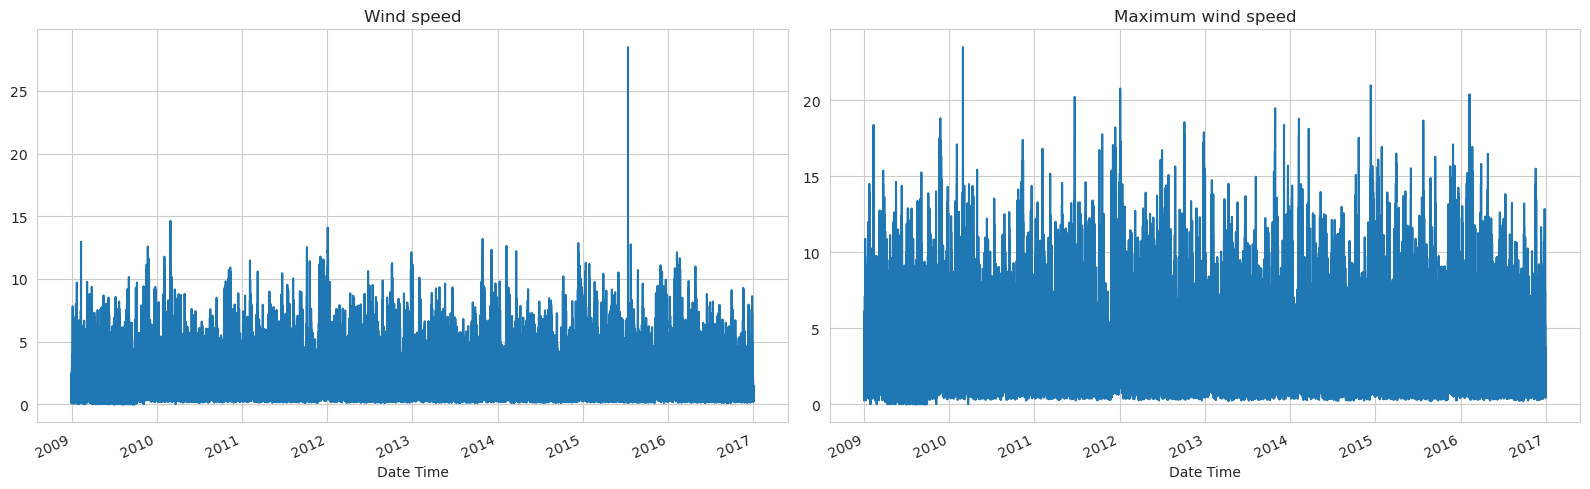

In [17]:
# Visualize the wind speed again
sns.set_style("whitegrid")
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
df_copy["wv (m/s)"].plot(title="Wind speed", rot=25, ax=axes[0])
df_copy["max. wv (m/s)"].plot(title="Maximum wind speed", rot=25, ax=axes[1])
plt.tight_layout()

### Temperature in Kelvin

In [18]:
df_copy.drop(columns=["Tpot (K)"], inplace=True)

## Feature Engineering 

### Wind direction and Wind Speed

- Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. 
- Direction shouldn't matter if the wind is not blowing.

We will convert the wind direction and wind speed columns to a wind vector

In [19]:
wv = df_copy.pop("wv (m/s)")
max_wv = df_copy.pop("max. wv (m/s)")

# Convert to radians.
wd_rad = df_copy.pop("wd (deg)") * np.pi / 180

# Calculate the wind x and y components.
df_copy["Wx"] = wv * np.cos(wd_rad)
df_copy["Wy"] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components.
df_copy["max Wx"] = max_wv * np.cos(wd_rad)
df_copy["max Wy"] = max_wv * np.sin(wd_rad)

In [20]:
df_copy.head()

,p (mbar),T (degC),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,-0.911955,0.478787,-1.549439,0.813474
2009-01-01 00:20:00,996.57,-8.41,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,-0.518797,0.499249,-1.080827,1.040103
2009-01-01 00:30:00,996.53,-8.51,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,-0.187962,0.027756,-0.623242,0.092032
2009-01-01 00:40:00,996.51,-8.31,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,-0.323359,-0.105066,-0.475528,-0.154508
2009-01-01 00:50:00,996.51,-8.27,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,-0.264351,-0.180328,-0.520442,-0.355021


In [21]:
df_copy.corr()["T (degC)"].sort_values(ascending=False)

T (degC)           1.000000
VPmax (mbar)       0.951113
Tdew (degC)        0.895708
VPact (mbar)       0.867673
H2OC (mmol/mol)    0.867177
sh (g/kg)          0.866755
VPdef (mbar)       0.761744
max Wy            -0.030566
Wy                -0.035534
max Wx            -0.040586
p (mbar)          -0.045375
Wx                -0.047985
rh (%)            -0.572416
rho (g/m**3)      -0.963410
Name: T (degC), dtype: float64

After converting the wind direction and wind speed columns to a wind vector, The new features correlates more with the temperature.

### Datetime

As the task is weather forecasting, we will add some datetime features to help our model learn the seasonality and time of day patterns.

We will add the following features:
- Month of the year (to identify seasonal patterns)
- Hour of the day (to identify day/night patterns)

In [22]:
# day and year in seconds
day = 24 * 60 * 60
year = (365.2425) * day

df_copy["Day sin"] = np.sin(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / day))
df_copy["Day cos"] = np.cos(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / day))
df_copy["Year sin"] = np.sin(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / year))
df_copy["Year cos"] = np.cos(df_copy.index.astype(np.int64) // 1e9 * (np.pi * 2 / year))

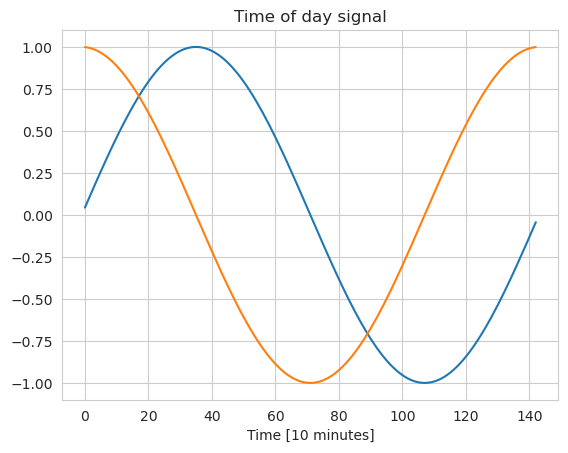

In [23]:
plt.plot(np.array(df_copy.loc["2009-1-1"]["Day sin"]))
plt.plot(np.array(df_copy.loc["2009-1-1"]["Day cos"]))
plt.xlabel("Time [10 minutes]")
plt.title("Time of day signal")
plt.show()

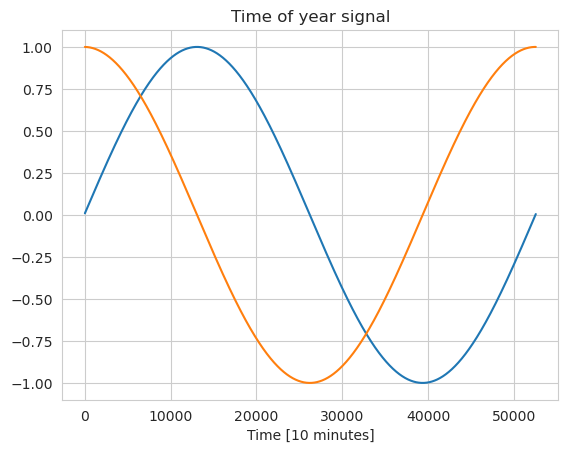

In [24]:
plt.plot(np.array(df_copy.loc["2009"]["Year sin"]))
plt.plot(np.array(df_copy.loc["2009"]["Year cos"]))
plt.xlabel("Time [10 minutes]")
plt.title("Time of year signal")
plt.show()

In [25]:
df_copy.head()

,p (mbar),T (degC),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,-0.911955,0.478787,-1.549439,0.813474,0.043619,0.999048,0.009452,0.999955
2009-01-01 00:20:00,996.57,-8.41,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,-0.518797,0.499249,-1.080827,1.040103,0.087156,0.996195,0.009571,0.999954
2009-01-01 00:30:00,996.53,-8.51,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,-0.187962,0.027756,-0.623242,0.092032,0.130526,0.991445,0.009691,0.999953
2009-01-01 00:40:00,996.51,-8.31,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,-0.323359,-0.105066,-0.475528,-0.154508,0.173648,0.984808,0.009810,0.999952
2009-01-01 00:50:00,996.51,-8.27,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,-0.264351,-0.180328,-0.520442,-0.355021,0.216440,0.976296,0.009930,0.999951


# Splitting the data

In [26]:
train_size = int(0.7 * len(df_copy))
val_size = int(0.15 * len(df_copy))
test_size = int(0.15 * len(df_copy))

# Split the data into train, validation, and test sets
train_df = df_copy.iloc[:train_size]
val_df = df_copy.iloc[train_size : train_size + val_size]
test_df = df_copy.iloc[train_size + val_size :]

# Normalize the data

In [27]:
sc = StandardScaler()
train_df_scaled = sc.fit_transform(train_df)
val_df_scaled = sc.transform(val_df)
test_df_scaled = sc.transform(test_df)

/tmp/ipykernel_34443/3545284321.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_copy.keys(), rotation=90)


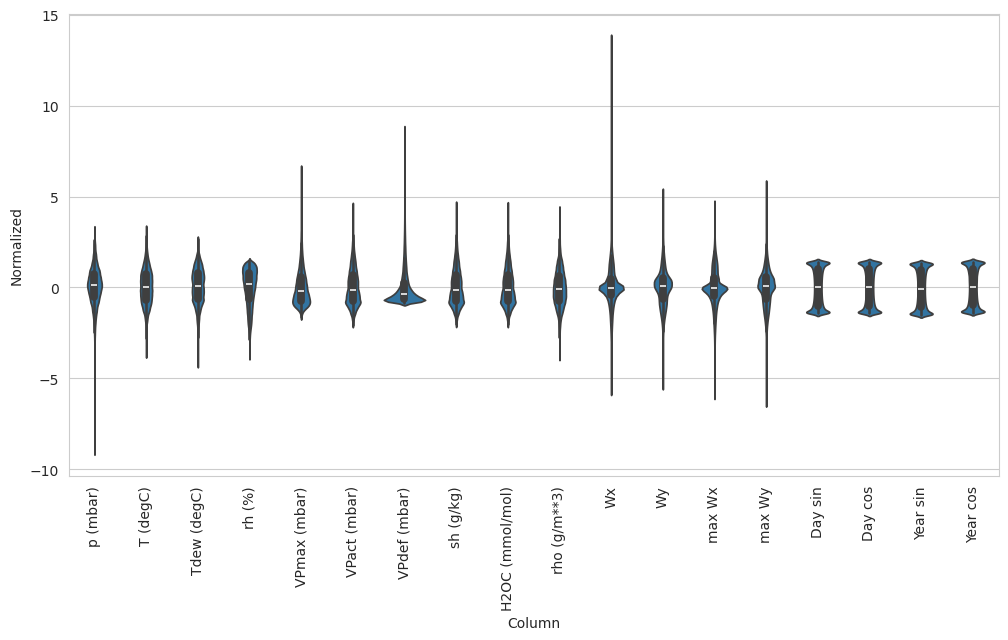

In [28]:
df_std = (df_copy - train_df.mean()) / train_df.std()
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df_copy.keys(), rotation=90)
plt.show()

# Data Windowing

The models will make a set of predictions based on a window of consecutive samples from the data.

So, we will create Dataset Class that will be responsible for splitting the data into windows.

We will make the dataset adapt to the type of model we want to train (multi-output or single-output) by changing the label_columns parameter.

In [29]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        label_column: str = None,
        input_width: int = 1,
        output_width: int = 1,
        shift: int = 1,
        transform: callable = None,
    ):
        self.data_df = data
        self.data = data.to_numpy()
        self.input_width = input_width
        self.output_width = output_width
        self.shift = shift
        self.transform = transform

        if label_column:
            self.label_column_idx = data.columns.get_loc(label_column)
        else:
            self.label_column_idx = slice(None)

    def __len__(self):
        return (
            self.data.shape[0] - (self.input_width + self.output_width + self.shift) + 1
        )

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = idx + self.input_width
        features = self.data[start_idx:end_idx]

        start_idx = end_idx + self.shift
        end_idx = start_idx + self.output_width
        labels = self.data[start_idx:end_idx, self.label_column_idx]
        return {"features": features, "labels": labels}

In [ ]:
def plot_window(
    dataset: TimeSeriesDataset,
    features_batch: torch.tensor,
    labels_batch: torch.tensor,
    model: nn.Module = None,
    plot_column: str = "T (degC)",
    num_samples: int = 1,
):
    """Plot the features, Labels and predictions for a single batch created by the dataloader"""
    _, axes = plt.subplots(
        nrows=num_samples,
        ncols=1,
        figsize=(14, 5 * num_samples),
        sharex=True,
        sharey=True,
    )
    plot_col_index = dataset.data_df.columns.get_loc(plot_column)

    for i, ax in enumerate(np.array(axes).reshape(-1)):
        features = features_batch[i, ...].numpy()
        labels = labels_batch[i, ...].numpy()
        if model:
            preds = model(features)

        # Plotting the features labels
        ax.plot(
            range(dataset.input_width),
            features[:, plot_col_index],
            label="Input Feature Labels",
            marker=".",
        )
        # Plotting the true labels
        ax.scatter(
            range(
                dataset.input_width + dataset.shift,
                dataset.input_width + dataset.shift + dataset.output_width,
            ),
            labels,
            label="True Labels",
            marker="o",
            c="green",
        )
        if model:
            # Plotting the predicted labels
            ax.scatter(
                range(
                    dataset.input_width + dataset.shift,
                    dataset.input_width + dataset.shift + dataset.output_width,
                ),
                preds,
                label="Predictions",
                marker="x",
                color="orange",
            )
    plt.legend(loc="upper left")
    plt.show()